Классификация изображений

Соревнование по https://www.kaggle.com/competitions/journey-springfield/leaderboard

В этом ноутбуке :

* рассмотрены Xceprion (два варианта) и ResNet + Transfer Learning

* написана кастомная архитектура - MyResNext - добавлена ещё одна голова после 3 conv слоя, к которой подгружены веса из pretrained модели (но не хватило ГПУ на Колабе чтобы обучить такую архитектуру)

Итоговый сабмит сделан со второй Xception

Score - 0.97449


# Imports

In [ ]:
!pip install -U torch torchvision
#!pip install torch==1.13.1 torchvision==0.14.1 torchaudio==0.13.1 torchtext==0.14.1 fastai==2.7.11

# установка подходящей версии torch
!pip3 install wheel==0.34.1

In [ ]:
from os.path import exists
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
import torch
from functools import partial
from typing import Any, Callable, List, Optional, Type, Union
from  torchvision.models.resnet import ResNet , Bottleneck
from torch import Tensor
import tensorflow as tf
from torch.optim.lr_scheduler import StepLR
import numpy as np
from torchvision import transforms
from sklearn.metrics import f1_score
import pickle
import numpy as np
from skimage import io
from tqdm import tqdm, tqdm_notebook
from PIL import Image
from pathlib import Path
from multiprocessing.pool import ThreadPool
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
from matplotlib import colors, pyplot as plt


import warnings
warnings.filterwarnings(action='ignore', category=DeprecationWarning)


In [ ]:
import PIL
print(PIL.PILLOW_VERSION)
# здесь должна быть версия 5.3.0.
if PIL.PILLOW_VERSION != '5.3.0':
    !pip uninstall -y Pillow
    !pip install Pillow==5.3.0

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive/')

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


In [ ]:
train_on_gpu = torch.cuda.is_available()
if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


# Download Dataset

In [ ]:
!unzip -q /content/gdrive/MyDrive/2023_DLS/1_part/data_simpson/dataset.zip -d train
!unzip -q /content/gdrive/MyDrive/2023_DLS/1_part/data_simpson/testset.zip -d test

replace train/dataset/simpsons_dataset/abraham_grampa_simpson/pic_0000.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: N
replace test/testset/testset/img0.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


In [ ]:
!ls test/

testset


In [ ]:
!nvidia-smi
import torch
torch.cuda.is_available()

Tue Apr 11 09:23:37 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   64C    P8    10W /  70W |      3MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

True

В нашем тесте будет 990 картнок, для которых будет необходимо предсказать класс.

# Hyperparameters

In [ ]:
# разные режимы датасета
DATA_MODES = ['train', 'val', 'test']
# все изображения будут масштабированы к размеру 224x224 px
RESCALE_SIZE = 224

In [ ]:
# работаем на видеокарте
DEVICE = torch.device("cuda")

# Dataset

In [ ]:

RESCALE_SIZE = 299
class SimpsonsDataset(Dataset):
    """
    Датасет с картинками, который паралельно подгружает их из папок
    производит скалирование и превращение в торчевые тензоры
    """
    def __init__(self, files, mode):
        super().__init__()
        # список файлов для загрузки
        self.files = sorted(files)
        # режим работы
        self.mode = mode

        if self.mode not in DATA_MODES:
            print(f"{self.mode} is not correct; correct modes: {DATA_MODES}")
            raise NameError

        self.len_ = len(self.files)

        self.label_encoder = LabelEncoder()

        if self.mode != 'test':
            self.labels = [path.parent.name for path in self.files]
            self.label_encoder.fit(self.labels)

            with open('label_encoder.pkl', 'wb') as le_dump_file:
                  pickle.dump(self.label_encoder, le_dump_file)

    def __len__(self):
        return self.len_

    def load_sample(self, file):
        image = Image.open(file)
        image.load()
        return image

    def __getitem__(self, index):
        # для преобразования изображений в тензоры PyTorch и нормализации входа
        transform = transforms.Compose([
            transforms.ToTensor(),
             transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])

        ])
        x = self.load_sample(self.files[index])
        x = self._prepare_sample(x)
        x = np.array(x / 255, dtype='float32')
        x = transform(x)
        if self.mode == 'test':
            return x
        else:
            label = self.labels[index]
            label_id = self.label_encoder.transform([label])
            y = label_id.item()
            return x, y

    def _prepare_sample(self, image):
        image = image.resize((RESCALE_SIZE, RESCALE_SIZE))
        return np.array(image)





In [ ]:
def imshow(inp, title=None, plt_ax=plt, default=False):
    """Imshow для тензоров"""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt_ax.imshow(inp)
    if title is not None:
        plt_ax.set_title(title)
    plt_ax.grid(False)

In [ ]:
TRAIN_DIR = Path('train/dataset')
TEST_DIR = Path('test/testset')

train_val_files = sorted(list(TRAIN_DIR.rglob('*.jpg')))
test_files = sorted(list(TEST_DIR.rglob('*.jpg')))

train_val_labels = [path.parent.name for path in train_val_files]
train_files, val_files = train_test_split(train_val_files, test_size=0.25, \
                                          stratify=train_val_labels)


val_dataset = SimpsonsDataset(val_files, mode='val')

Давайте посмотрим на наших героев внутри датасета.

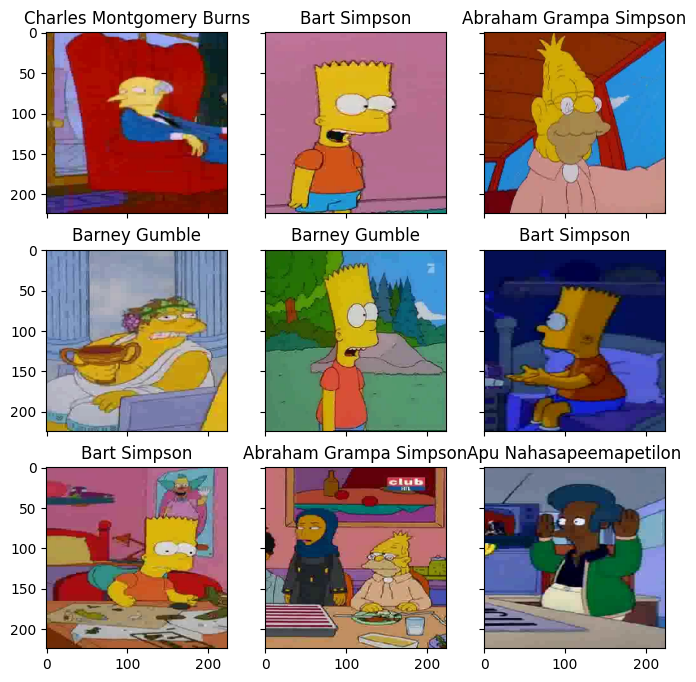

In [ ]:
fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(8, 8), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,1000))
    im_val, label = val_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),\
                val_dataset.label_encoder.inverse_transform([label])[0].split('_')))
    imshow(im_val.data.cpu(), \
          title=img_label,plt_ax=fig_x)

In [ ]:
def predict_one_sample(model, inputs, device=DEVICE):
    """Предсказание, для одной картинки"""
    with torch.no_grad():
        inputs = inputs.to(device)
        model.eval()
        logit = model(inputs).cpu()
        probs = torch.nn.functional.softmax(logit, dim=-1).numpy()
    return probs

# Train


Можно попробовать усовершенствованную модель incevtion - Xception (она более лёгкая и имеет меньше парметров, оставлю ссылки на предыдущее решение и на пару статей)

https://towardsdatascience.com/review-xception-with-depthwise-separable-convolution-better-than-inception-v3-image-dc967dd42568



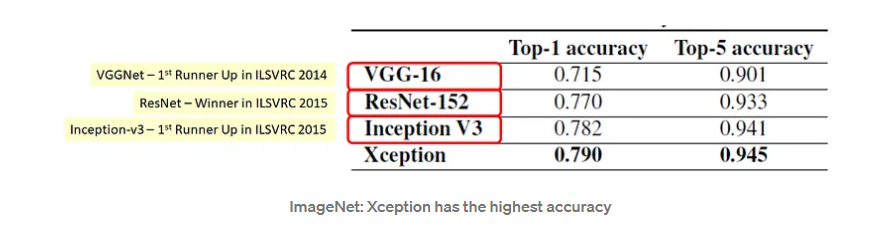

https://habr.com/ru/post/347564/ - статья на хабре

http://openaccess.thecvf.com/content_cvpr_2017/papers/Chollet_Xception_Deep_Learning_CVPR_2017_paper.pdf - статья arxiv


https://medium.com/analytics-vidhya/image-recognition-using-pre-trained-xception-model-in-5-steps-96ac858f4206 - то что помогло найти pretrined model  под TensorFlow

## Train / val functions

In [ ]:
!pip install pretrainedmodels
!pip install tf-explain

In [ ]:
import pretrainedmodels as ptm
from tf_explain.core.activations import ExtractActivations
from tensorflow.keras.applications.xception import decode_predictions
from pretrainedmodels.models.xception import Xception, pretrained_settings as xception_settings

In [ ]:
## base functions for learning

def eval_epoch(model, val_loader, criterion):
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    processed_size = 0

    for inputs, labels in val_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)

        with torch.set_grad_enabled(False):
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            preds = torch.argmax(outputs, 1)

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_size += inputs.size(0)
    val_loss = running_loss / processed_size
    val_acc = running_corrects.double() / processed_size
    return val_loss, val_acc



def fit_epoch(model, train_loader, criterion, optimizer):
    running_loss = 0.0
    running_corrects = 0
    processed_data = 0

    for inputs, labels in train_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        preds = torch.argmax(outputs, 1)
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_data += inputs.size(0)

    train_loss = running_loss / processed_data
    train_acc = running_corrects.cpu().numpy() / processed_data
    return train_loss, train_acc


def train(train_files, val_files, model, epochs, batch_size):
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    history = []
    log_template = "\nEpoch {ep:03d} train_loss: {t_loss:0.4f} \
    val_loss {v_loss:0.4f} train_acc {t_acc:0.4f} val_acc {v_acc:0.4f}"

    with tqdm(desc="epoch", total=epochs) as pbar_outer:
      # мф будем использовать тот же оптимизатор что и авторы оригинальной статьи где Xception была представлена
        opt =  torch.optim.SGD(model.parameters(), momentum = 0.9, lr = 0.045)
       # opt = torch.optim.Adam(model.parameters())
        criterion = nn.CrossEntropyLoss()

        scheduler = StepLR(opt, step_size=2, gamma=0.95)


        # ---------------------------------

        for epoch in range(epochs):
            train_loss, train_acc = fit_epoch(model, train_loader, criterion, opt)
            scheduler.step()
            print("loss", train_loss)

            val_loss, val_acc = eval_epoch(model, val_loader, criterion)
            history.append((train_loss, train_acc, val_loss, val_acc))

            pbar_outer.update(1)
            tqdm.write(log_template.format(ep=epoch+1, t_loss=train_loss,\
                                           v_loss=val_loss, t_acc=train_acc, v_acc=val_acc))


    return history


def predict(model, test_loader):
    with torch.no_grad():
        logits = []

        for inputs in test_loader:
            inputs = inputs.to(DEVICE)
            model.eval()
            outputs = model(inputs).cpu()
            logits.append(outputs)

    probs = nn.functional.softmax(torch.cat(logits), dim=-1).numpy()
    return probs



## Xceprion



### Первая попытка обучения

подменили только классификатор и заморозили веса

In [ ]:
# download weights by 'wget http://data.lip6.fr/cadene/pretrainedmodels/xception-b5690688.pth --no-check-certificate' in cmd -> load to local GoogleDrive
state_dict = torch.load('/content/gdrive/MyDrive/2023_DLS/1_part/data_simpson/Xception_pretrained/xception-b5690688.pth')

for name, weights in state_dict.items():
    if 'pointwise' in name:
        state_dict[name] = weights.unsqueeze(-1).unsqueeze(-1)

model = Xception(num_classes=1000)
model.load_state_dict(state_dict)
torch.save(state_dict, '/content/gdrive/MyDrive/2023_DLS/1_part/data_simpson/Xception_pretrained/xception-fixed.pth')

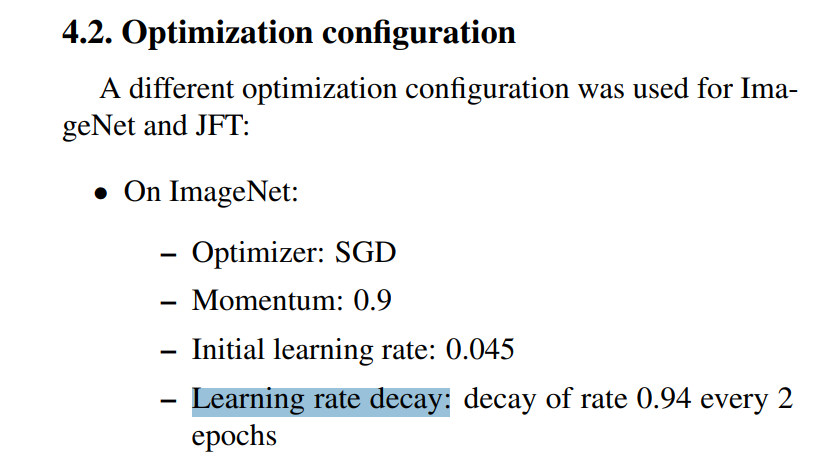

In [ ]:
if val_dataset is None:
    val_dataset = SimpsonsDataset(val_files, mode='val')

train_dataset = SimpsonsDataset(train_files, mode='train')

In [ ]:
i = 0

for param in model.parameters():
  i += param.requires_grad
  param.requires_grad = False
print(i , " params in total")
print("we need input size = (299, 299, 3) ")



model.last_linear = model.fc  # как соверуют разрабы исправлять этот баг =)
del model.fc
model.last_linear  = torch.nn.Linear(2048, 42)
model.last_linear.requires_grad = True

model  = model.to(DEVICE)

156  params in total
we need input size = (299, 299, 3) 


In [ ]:
#!pip install --upgrade pretrainedmodels

In [ ]:
history = train(train_dataset, val_dataset, model=model, epochs=8, batch_size=64)

epoch:   0%|          | 0/8 [00:00<?, ?it/s]

loss 1.8483281710305952


epoch:  12%|█▎        | 1/8 [04:20<30:26, 260.89s/it]


Epoch 001 train_loss: 1.8483     val_loss 1.3925 train_acc 0.5322 val_acc 0.6379
loss 1.1835824166432225


epoch:  25%|██▌       | 2/8 [08:17<24:39, 246.62s/it]


Epoch 002 train_loss: 1.1836     val_loss 1.1791 train_acc 0.6926 val_acc 0.6941
loss 0.9933996777662358


epoch:  38%|███▊      | 3/8 [12:12<20:05, 241.14s/it]


Epoch 003 train_loss: 0.9934     val_loss 1.1010 train_acc 0.7360 val_acc 0.7113
loss 0.8733811726182257


epoch:  50%|█████     | 4/8 [16:05<15:53, 238.26s/it]


Epoch 004 train_loss: 0.8734     val_loss 1.0613 train_acc 0.7702 val_acc 0.7195
loss 0.7974568626912386


epoch:  62%|██████▎   | 5/8 [19:59<11:49, 236.64s/it]


Epoch 005 train_loss: 0.7975     val_loss 1.0143 train_acc 0.7902 val_acc 0.7276
loss 0.7315159768608392


epoch:  75%|███████▌  | 6/8 [23:53<07:51, 235.59s/it]


Epoch 006 train_loss: 0.7315     val_loss 0.9999 train_acc 0.8073 val_acc 0.7321
loss 0.6836361161948268


epoch:  88%|████████▊ | 7/8 [27:47<03:55, 235.04s/it]


Epoch 007 train_loss: 0.6836     val_loss 0.9587 train_acc 0.8207 val_acc 0.7421
loss 0.641142851699347


epoch: 100%|██████████| 8/8 [31:40<00:00, 237.57s/it]


Epoch 008 train_loss: 0.6411     val_loss 0.9647 train_acc 0.8322 val_acc 0.7411


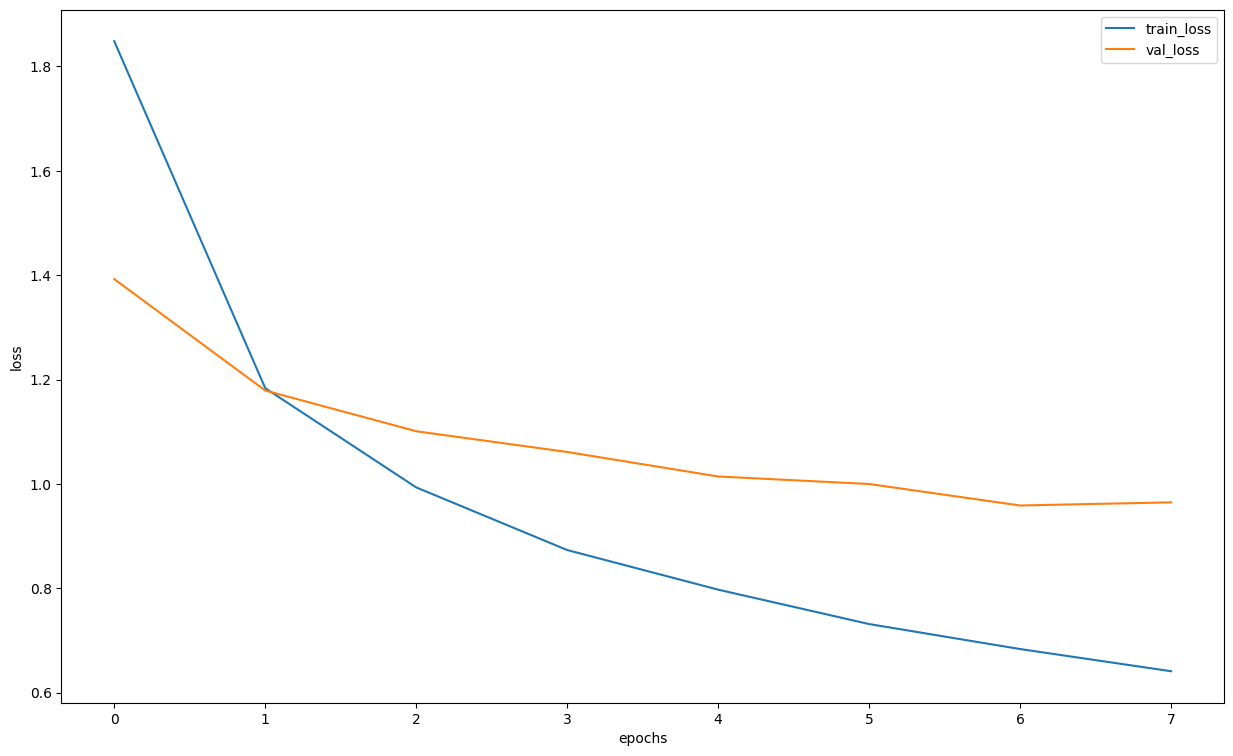

In [ ]:

loss, acc, val_loss, val_acc = zip(*history)
plt.figure(figsize=(15, 9))
plt.plot(loss, label="train_loss")
plt.plot(val_loss, label="val_loss")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

# *-*-*-*-*-* 06-04-2023

In [ ]:
torch.save(model, '/content/gdrive/MyDrive/2023_DLS/1_part/data_simpson/saved_models/model_x_0.pth')

Сделаем предикты с этой моделью

In [ ]:

test_dataset = SimpsonsDataset(test_files, mode="test")
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=64)
probs = predict(model, test_loader)


preds = label_encoder.inverse_transform(np.argmax(probs, axis=1))
test_filenames = [path.name for path in test_dataset.files]

my_submit_x_0 = pd.DataFrame({'Id': test_filenames, 'Expected': preds})
my_submit_x_0.head()

,Id,Expected
0,img0.jpg,nelson_muntz
1,img1.jpg,bart_simpson
2,img10.jpg,ned_flanders
3,img100.jpg,chief_wiggum
4,img101.jpg,apu_nahasapeemapetilon


In [ ]:
my_submit.to_csv('/content/gdrive/MyDrive/2023_DLS/1_part/data_simpson/subs/my_submit_x_0.csv', index=False)

Сабмит с этой моделью даёт скор = 0,69
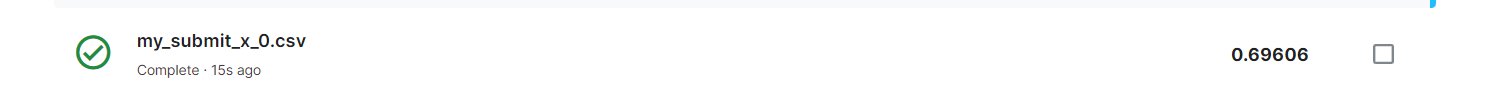

### Вторая Xception

Замораживаем веса, размораживаем последние conv слои

In [ ]:
del model

model_X1 = Xception(num_classes=1000)
model_X1.load_state_dict(torch.load('/content/gdrive/MyDrive/2023_DLS/1_part/data_simpson/Xception_pretrained/xception-fixed.pth'))
i = 0

# морозим веса
for param in model_X1.parameters():
  i += param.requires_grad
  param.requires_grad = False
print(i , " params in total")
print("we need input size = (299, 299, 3) ")



model_X1.last_linear = model_X1.fc
del model_X1.fc
model_X1.last_linear  = torch.nn.Linear(2048, 42)
model_X1.last_linear.requires_grad = True


156  params in total
we need input size = (299, 299, 3) 


In [ ]:
params_x1 = model_X1.named_parameters()
par_to_update = []

for name, param in params_x1:

  if param.requires_grad == True:
      print(name)
      print(param)
      print('**')

      par_to_update.append(param)


last_linear.weight
Parameter containing:
tensor([[-1.9593e-02,  2.0062e-02,  1.4282e-02,  ...,  7.9445e-03,
         -6.4504e-03,  9.8834e-03],
        [ 1.5402e-02,  2.1880e-02, -5.2262e-03,  ...,  9.6472e-03,
          6.6160e-03,  9.1182e-03],
        [ 1.1818e-02, -1.0332e-02,  8.7112e-06,  ..., -9.4865e-03,
          6.5580e-03, -3.4643e-03],
        ...,
        [-1.5599e-02, -1.6585e-02, -1.3635e-02,  ..., -2.0158e-02,
          1.6532e-02, -9.3251e-03],
        [-5.5581e-03, -2.2030e-03, -7.3332e-03,  ...,  4.9390e-03,
         -1.7503e-02, -5.1502e-03],
        [-8.6275e-03,  1.9598e-02,  1.2424e-02,  ..., -1.3025e-02,
         -3.0574e-03,  7.3888e-03]], requires_grad=True)
**
last_linear.bias
Parameter containing:
tensor([ 0.0080, -0.0031,  0.0093, -0.0046,  0.0158, -0.0178, -0.0081,  0.0021,
        -0.0218, -0.0191, -0.0079, -0.0122, -0.0151,  0.0094, -0.0187,  0.0189,
        -0.0219,  0.0127, -0.0087,  0.0143, -0.0046,  0.0070, -0.0164,  0.0122,
        -0.0136,  0.0093,

In [ ]:
print('parameters requires_grad :' )
print("in conv3")
for param in model_X1.conv3.parameters():
  print(param.requires_grad)
print("in block12")
for param in model_X1.block12.parameters():
  print(param.requires_grad)

parameters requires_grad :
in conv3
False
False
in block12
False
False
False
False
False
False
False
False
False
False
False


In [ ]:
# разморозим 12-последний блок и классификатор
for param in model_X1.conv3.parameters():
  param.requires_grad = True
  print(param.requires_grad)
print("in block12")
for param in model_X1.block12.parameters():
  param.requires_grad = True
  print(param.requires_grad)

print('new req_gred = True params :')
print(model_X1.block12)
print(model_X1.conv3)

True
True
in block12
True
True
True
True
True
True
True
True
True
True
True
new req_gred = True params :
Block(
  (skip): Conv2d(728, 1024, kernel_size=(1, 1), stride=(2, 2), bias=False)
  (skipbn): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (rep): Sequential(
    (0): ReLU()
    (1): SeparableConv2d(
      (conv1): Conv2d(728, 728, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=728, bias=False)
      (pointwise): Conv2d(728, 728, kernel_size=(1, 1), stride=(1, 1), bias=False)
    )
    (2): BatchNorm2d(728, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): ReLU(inplace=True)
    (4): SeparableConv2d(
      (conv1): Conv2d(728, 728, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=728, bias=False)
      (pointwise): Conv2d(728, 1024, kernel_size=(1, 1), stride=(1, 1), bias=False)
    )
    (5): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)

In [ ]:
model_X1  = model_X1.to(DEVICE)
history = train(train_dataset, val_dataset, model=model_X1, epochs=8, batch_size=64)

epoch:   0%|          | 0/8 [00:00<?, ?it/s]

loss 1.2154740900630836


epoch:  12%|█▎        | 1/8 [04:28<31:20, 268.67s/it]


Epoch 001 train_loss: 1.2155     val_loss 0.4813 train_acc 0.6818 val_acc 0.8783
loss 0.35302394041932156


epoch:  25%|██▌       | 2/8 [08:44<26:06, 261.13s/it]


Epoch 002 train_loss: 0.3530     val_loss 0.3849 train_acc 0.9072 val_acc 0.9047
loss 0.17875754406138342


epoch:  38%|███▊      | 3/8 [12:59<21:32, 258.48s/it]


Epoch 003 train_loss: 0.1788     val_loss 0.2848 train_acc 0.9522 val_acc 0.9284
loss 0.08833366621783284


epoch:  50%|█████     | 4/8 [17:14<17:08, 257.07s/it]


Epoch 004 train_loss: 0.0883     val_loss 0.2985 train_acc 0.9749 val_acc 0.9341
loss 0.040197613210712704


epoch:  62%|██████▎   | 5/8 [21:29<12:49, 256.35s/it]


Epoch 005 train_loss: 0.0402     val_loss 0.3331 train_acc 0.9887 val_acc 0.9320


epoch:  62%|██████▎   | 5/8 [24:21<14:37, 292.35s/it]


KeyboardInterrupt: ignored

Лосс на train падал, а на val начинал расти, поэтому остановила обучение на 5 эпохе

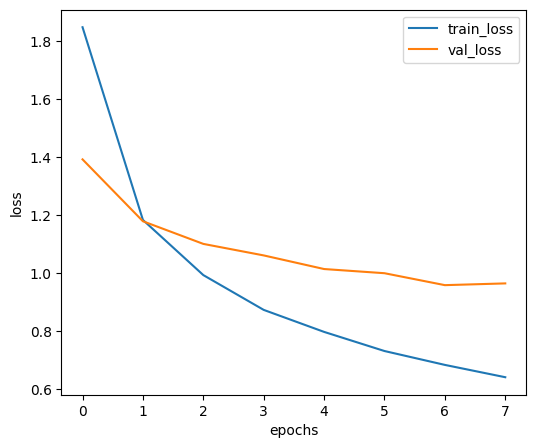

In [ ]:
loss, acc, val_loss, val_acc = zip(*history)
plt.figure(figsize=(6, 5))
plt.plot(loss, label="train_loss")
plt.plot(val_loss, label="val_loss")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

# *-*-*-*-*-* 06-04-2023

Сохраним модель, сделаем сабмит

In [ ]:
idxs = list(map(int, np.random.uniform(0,1000, 20)))
imgs = [val_dataset[id][0].unsqueeze(0) for id in idxs]

In [ ]:
probs_ims = predict(model_X1, imgs)
label_encoder = pickle.load(open("label_encoder.pkl", 'rb'))
y_pred = np.argmax(probs_ims,-1)
actual_labels = [val_dataset[id][1] for id in idxs]
preds_class = [label_encoder.classes_[i] for i in y_pred]
f1_score(actual_labels, y_pred, average = 'micro')

0.9

In [ ]:
torch.save(model_X1, '/content/gdrive/MyDrive/2023_DLS/1_part/data_simpson/saved_models/model_X1.pth')

In [ ]:
test_dataset = SimpsonsDataset(test_files, mode="test")
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=64)
probs = predict(model_X1, test_loader)


preds = label_encoder.inverse_transform(np.argmax(probs, axis=1))
test_filenames = [path.name for path in test_dataset.files]

my_submit_model_X1 = pd.DataFrame({'Id': test_filenames, 'Expected': preds})
my_submit_model_X1.head()

,Id,Expected
0,img0.jpg,nelson_muntz
1,img1.jpg,bart_simpson
2,img10.jpg,ned_flanders
3,img100.jpg,chief_wiggum
4,img101.jpg,apu_nahasapeemapetilon


In [ ]:
my_submit_model_X1.to_csv('/content/gdrive/MyDrive/2023_DLS/1_part/data_simpson/subs/my_submit_model_X1.csv', index=False)

Сабмит уже с этой моделью даёт скор = 0,9713
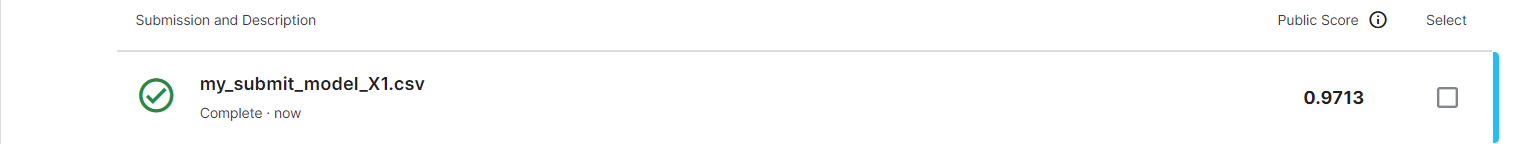

Попробуем  ResNet


## ResNet


ссылка на исходный пост - https://paperswithcode.com/paper/aggregated-residual-transformations-for-deep

там уже есть бейзлайновский ноутбук, код из которого использовался местами

# ResNext (= Inception + ResNet)



**Next generation ResNets, more efficient and accurate**

<img src="https://pytorch.org/assets/images/resnext.png" alt="alt" width="50%"/>

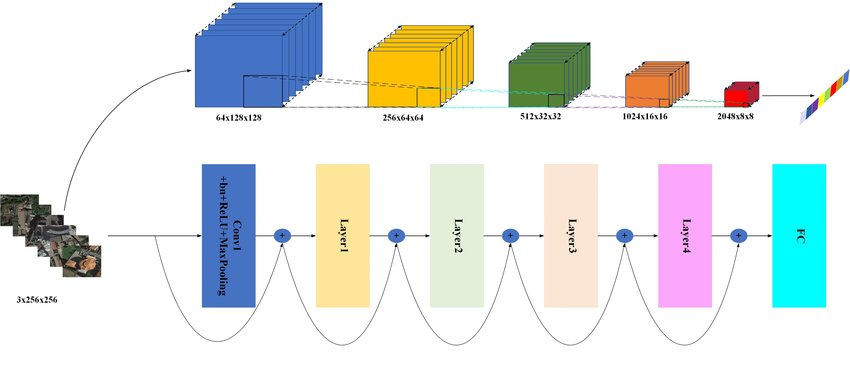

У ResNext есть 4 блока (layers) которые состоят из свёрток, нормализаций и активаций, каждый такой блок выглядит так, как на картирке ниже (справа).

Создадим свою модель (с кастомным __init__ и  __forward__ чтобы потом прикрутить ещё одну голову к нейронке после 3 слоя ) с шириной (= cardinality) блоков 3,4,23,3 соответственно

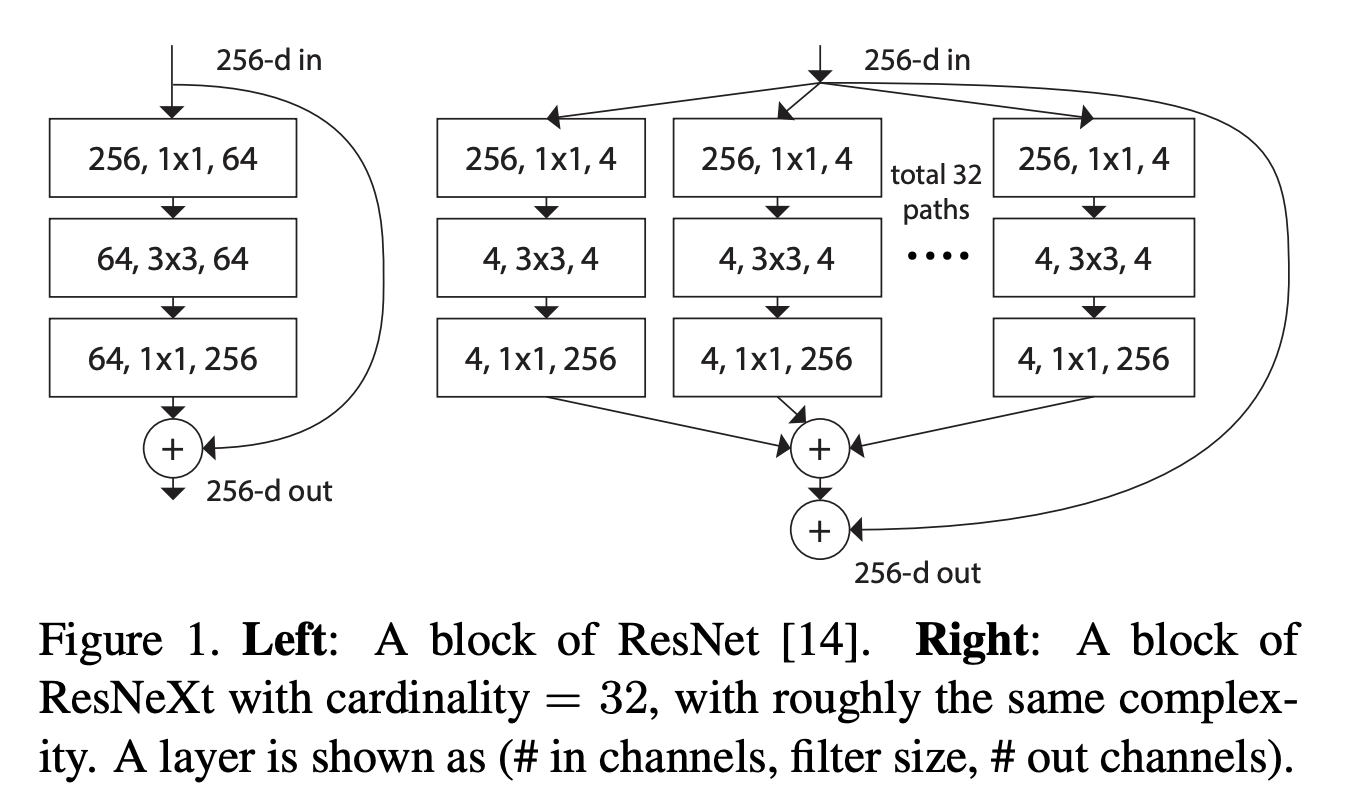

In [ ]:
class CustomHead(nn.Module):
  def __init__(self, input_size, output_size):
    super(CustomHead, self).__init__()

    # one of heads from GoogleNet

    self.avgpool = nn.AdaptiveAvgPool2d((4, 4))
    self.conv = nn.Conv2d(1024, 128, (1,1) , bias=False)
    self.bn = nn.BatchNorm2d(128, eps=0.001)
    self.relu = nn.ReLU(True)

    self.relu = nn.ReLU(True)
    self.fc1 = nn.Linear(2048, 1024)
    self.fc2 = nn.Linear(1024, n_classes)



  def forward(self, inputs):

    out = self.avgpool(inputs)
    out = self.relu(self.bn(self.conv(out)))
    out = torch.flatten(out, 1)
    out = self.fc1(out)
    out = self.relu(out)
    out = self.fc2(out)

    return out


In [ ]:
## create custom model class (based on https://github.com/pytorch/vision/blob/main/torchvision/models/resnet.py)
class MyResNext(ResNet):
  def __init__(
        self,
        block,
        layers,
        num_classes: int = 1000,
        zero_init_residual: bool = False,
        groups: int = 1,
        width_per_group: int = 64,

       replace_stride_with_dilation: Optional[List[bool]] = None,
        norm_layer: Optional[Callable[..., nn.Module]] = None,
        **kwargs
    ):
        super(MyResNext, self).__init__(block, layers)

        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        self._norm_layer = norm_layer

        self.inplanes = 64
        self.dilation = 1
        if replace_stride_with_dilation is None:
            # each element in the tuple indicates if we should replace
            # the 2x2 stride with a dilated convolution instead
            replace_stride_with_dilation = [False, False, False]
        if len(replace_stride_with_dilation) != 3:
            raise ValueError(
                "replace_stride_with_dilation should be None "
                f"or a 3-element tuple, got {replace_stride_with_dilation}"
            )
        self.groups = groups
        self.base_width = width_per_group
        self.conv1 = nn.Conv2d(3, self.inplanes, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = norm_layer(self.inplanes)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2, dilate=replace_stride_with_dilation[0])
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2, dilate=replace_stride_with_dilation[1])
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2, dilate=replace_stride_with_dilation[2])
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * block.expansion, num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode="fan_out", nonlinearity="relu")
            elif isinstance(m, (nn.BatchNorm2d, nn.GroupNorm)):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)



        # Zero-initialize the last BN in each residual branch,
        # so that the residual branch starts with zeros, and each residual block behaves like an identity.
        # This improves the model by 0.2~0.3% according to https://arxiv.org/abs/1706.02677
        if zero_init_residual:
            for m in self.modules():
                if isinstance(m, Bottleneck) and m.bn3.weight is not None:
                    nn.init.constant_(m.bn3.weight, 0)  # type: ignore[arg-type]


        # можем подгружать только если необходимо

        self.custom_head_only = kwargs.get("custom_head_only", False)

        if kwargs.get("new_head", False):
          self.new_head = CustomHead(1024*14*14, 1024)
          print("head created")
        else:
          print("head not created")





  def _forward_impl(self, x: Tensor) -> Tensor:
      # See note [TorchScript super()]
      x = self.conv1(x)
      x = self.bn1(x)
      x = self.relu(x)
      x = self.maxpool(x)

      x = self.layer1(x)
      x = self.layer2(x)
      x = self.layer3(x)
      # add new head
      if hasattr(self, "new_head"):
        new_head_logits = self.new_head(x)
        #print("HEAD created")
      else:
        new_head_logits = None
        #print("no head in forward")

      if self.custom_head_only:
        return new_head_logits


      x = self.layer4(x)
      x = self.avgpool(x)
      x = torch.flatten(x, 1)
      x = self.fc(x)

      return x, new_head_logits

  def forward(self, x: Tensor) -> Tensor:
      return self._forward_impl(x)


  def set_params_req_grad(self, params):
    for name, param in self.named_parameters():
      if name.split('.')[0] in params:
        param.requires_grad = True
      else:
        param.requires_grad = False



  def set_params_to_train(self, params):
    self.eval()
    for param in params:
      train_param = getattr(self, param)
      train_param.train()



  https://github.com/pytorch/vision/blob/main/torchvision/models/resnet.py

  У нас модель ResNet101, тут можно скачать веса для неё.

In [ ]:
# создали модельку
MyResNext_m = MyResNext(block = Bottleneck, layers= [3, 4, 23, 3])

# try to load weights from pretrained model
resNetW = "/content/gdrive/MyDrive/2023_DLS/1_part/data_simpson/additional_models_frameworks/Models_pretrained_weights/resnet101-63fe2227.pth"

checkpoint = torch.load(resNetW, map_location="cpu")
MyResNext_m.load_state_dict(checkpoint, strict=True)
# strict = True значит, что мы загружаем веса строго для всей архитектруы, когда мы прилепим ещё одну голову,
# то нужно будет заменить на strict = False. потому что у нас нет скачанных весов для нашей кастомной головы


head not created


<All keys matched successfully>

In [ ]:
MyResNext_m = MyResNext(block = Bottleneck, layers= [3, 4, 23, 3],\
                        new_head = True,custom_head_only = True )
MyResNext_m.new_head

head created


CustomHead(
  (fc1): Linear(in_features=200704, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=42, bias=True)
)

In [ ]:
MyResNext_m.load_state_dict(checkpoint, strict=False)

_IncompatibleKeys(missing_keys=['new_head.fc1.weight', 'new_head.fc1.bias', 'new_head.fc2.weight', 'new_head.fc2.bias'], unexpected_keys=[])

проверим, что можем получать выходы с двух голов, при желании только с одной

In [ ]:
RESCALE_SIZE = 224 # как в офф статье
X_one = next(iter(train_dataset))[0]
X_one[None, :].shape

torch.Size([1, 3, 224, 224])

In [ ]:
MyResNext_m = MyResNext(block = Bottleneck, layers= [3, 4, 23, 3],\
                        new_head = True,custom_head_only = False )
outp_1, outp_2 = MyResNext_m(X_one[None, :])

print(outp_1.shape)
print(outp_2.shape)

head created
torch.Size([1, 1000])
torch.Size([1, 42])


С первой головы у нас 42 выхода, с другой 1000

In [ ]:
MyResNext_m = MyResNext(block = Bottleneck, layers= [3, 4, 23, 3],\
                        new_head = True,custom_head_only = True )


head created



Теперь мы не грузили голову с 1000 выходами

In [ ]:
outp_1 = MyResNext_m(X_one[None, :])
print(outp_1.shape)

torch.Size([1, 42])


In [ ]:
outp_1

tensor([[ 0.0028, -0.1559, -0.1619, -0.3481,  0.1275, -0.1042, -0.0959, -0.1248,
         -0.0017,  0.0148,  0.0592, -0.0761, -0.1104,  0.0470, -0.0841,  0.3292,
         -0.0030, -0.3706, -0.0365, -0.0161,  0.0455,  0.0847, -0.0185, -0.3976,
          0.1582,  0.1433, -0.0278, -0.0576, -0.0503,  0.1030,  0.0467,  0.1467,
          0.0006,  0.0907,  0.0038,  0.0801, -0.2610,  0.1606, -0.1045, -0.1670,
         -0.1338, -0.2328]], grad_fn=<AddmmBackward0>)

Посмотрим на обучаемые параметры

In [ ]:
from prettytable import PrettyTable

def count_parameters(model):
    table = PrettyTable(["Modules", "Parameters"])
    total_params = 0
    for name, parameter in model.named_parameters():
        if not parameter.requires_grad: continue
        params = parameter.numel()
        table.add_row([name, params])
        total_params+=params
    print(table)
    print(f"Total Trainable Params: {total_params}")
    return total_params

In [ ]:
сount_parameters(MyResNext_m)

+------------------------------+------------+
|           Modules            | Parameters |
+------------------------------+------------+
|         conv1.weight         |    9408    |
|          bn1.weight          |     64     |
|           bn1.bias           |     64     |
|    layer1.0.conv1.weight     |    4096    |
|     layer1.0.bn1.weight      |     64     |
|      layer1.0.bn1.bias       |     64     |
|    layer1.0.conv2.weight     |   36864    |
|     layer1.0.bn2.weight      |     64     |
|      layer1.0.bn2.bias       |     64     |
|    layer1.0.conv3.weight     |   16384    |
|     layer1.0.bn3.weight      |    256     |
|      layer1.0.bn3.bias       |    256     |
| layer1.0.downsample.0.weight |   16384    |
| layer1.0.downsample.1.weight |    256     |
|  layer1.0.downsample.1.bias  |    256     |
|    layer1.1.conv1.weight     |   16384    |
|     layer1.1.bn1.weight      |     64     |
|      layer1.1.bn1.bias       |     64     |
|    layer1.1.conv2.weight     |  

46821714

Сейчас наша голова похожа на голову из GoogleNet. только без DropOut

https://www.ruder.io/multi-task/#deeprelationshipnetworks - статья про то, почему multi-task nn могут быть полезны


Мы сейчас и пытаемся сделать такую нейронку с одним телом и несколькими головами, напимер одну из голов можно использовать для задачи классификации по лицам, другую голову на определение пола человека по его лицу и тд

### Train / valid functions

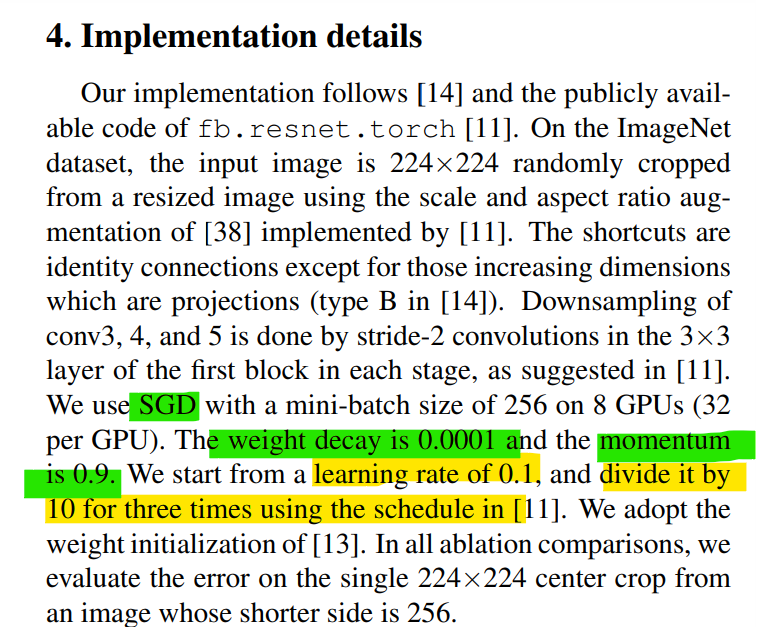

In [ ]:
MyResNext_m.set_params_req_grad(['new_head'])
MyResNext_m.set_params_to_train( ['new_head'])
count_parameters(MyResNext_m)

+----------------------+------------+
|       Modules        | Parameters |
+----------------------+------------+
| new_head.conv.weight |   131072   |
|  new_head.bn.weight  |    128     |
|   new_head.bn.bias   |    128     |
| new_head.fc1.weight  |  2097152   |
|  new_head.fc1.bias   |    1024    |
| new_head.fc2.weight  |   43008    |
|  new_head.fc2.bias   |     42     |
+----------------------+------------+
Total Trainable Params: 2272554


2272554

In [ ]:
MyResNext_m.new_head.fc2.weight
# проверили что веса заполнились нормально

Parameter containing:
tensor([[-0.0293,  0.0033, -0.0139,  ..., -0.0223, -0.0005,  0.0282],
        [ 0.0231, -0.0296,  0.0075,  ...,  0.0027,  0.0158, -0.0299],
        [-0.0117,  0.0039, -0.0295,  ..., -0.0006,  0.0013, -0.0168],
        ...,
        [-0.0041, -0.0148, -0.0295,  ..., -0.0112, -0.0310,  0.0209],
        [-0.0208, -0.0197,  0.0252,  ..., -0.0297,  0.0223, -0.0304],
        [-0.0191,  0.0055,  0.0251,  ...,  0.0086, -0.0157, -0.0285]],
       requires_grad=True)

In [ ]:
def fit_epoch(model, train_loader, criterion, optimizer):
    running_loss = 0.0
    running_corrects = 0
    processed_data = 0

    for inputs, labels in train_loader:
        #print("inputs = ", inputs)
        #print("inputs shape = ", inputs.shape)
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        preds = torch.argmax(outputs, 1)
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_data += inputs.size(0)

    train_loss = running_loss / processed_data
    train_acc = running_corrects.cpu().numpy() / processed_data
    return train_loss, train_acc


def train(train_files, val_files, model, epochs, batch_size, \
         weight_decay=0.0001, lr = 0.1
):
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    history = []
    log_template = "\nEpoch {ep:03d} train_loss: {t_loss:0.4f} \
    val_loss {v_loss:0.4f} train_acc {t_acc:0.4f} val_acc {v_acc:0.4f}"

    with tqdm(desc="epoch", total=epochs) as pbar_outer:
      # будем использовать тот же оптимизатор что и авторы оригинальной статьи где ResNext была представлена

        opt =  torch.optim.SGD(model.parameters(), momentum = 0.9, lr = lr, weight_decay = weight_decay )
        criterion = nn.CrossEntropyLoss()
        scheduler = StepLR(opt, step_size=3, gamma=0.7)
        for epoch in range(epochs):
            train_loss, train_acc = fit_epoch(model, train_loader, criterion, opt)
            scheduler.step()
            print("loss", train_loss)

            val_loss, val_acc = eval_epoch(model, val_loader, criterion)
            history.append((train_loss, train_acc, val_loss, val_acc))

            pbar_outer.update(1)
            tqdm.write(log_template.format(ep=epoch+1, t_loss=train_loss,\
                                           v_loss=val_loss, t_acc=train_acc, v_acc=val_acc))


    return history



In [ ]:
#del MyResNext_m
MyResNext_m  = MyResNext_m.to(DEVICE)


In [ ]:
history = train(train_dataset, val_dataset, model=MyResNext_m, epochs=8, batch_size=64)
# lr_dacay = 0.0001

epoch:   0%|          | 0/8 [00:00<?, ?it/s]

loss 3.1746335450278185


epoch:  12%|█▎        | 1/8 [02:29<17:25, 149.31s/it]


Epoch 001 train_loss: 3.1746     val_loss 3.0701 train_acc 0.1042 val_acc 0.1253
loss 3.0374687433592094


epoch:  25%|██▌       | 2/8 [04:52<14:34, 145.73s/it]


Epoch 002 train_loss: 3.0375     val_loss 2.9866 train_acc 0.1231 val_acc 0.1412
loss 2.974538862769775


epoch:  38%|███▊      | 3/8 [07:13<11:58, 143.67s/it]


Epoch 003 train_loss: 2.9745     val_loss 2.9524 train_acc 0.1394 val_acc 0.1410
loss 2.9199730803825434


epoch:  50%|█████     | 4/8 [09:35<09:31, 142.83s/it]


Epoch 004 train_loss: 2.9200     val_loss 2.9467 train_acc 0.1573 val_acc 0.1513
loss 2.9019206253781697


epoch:  62%|██████▎   | 5/8 [11:56<07:06, 142.17s/it]


Epoch 005 train_loss: 2.9019     val_loss 2.9035 train_acc 0.1634 val_acc 0.1691
loss 2.8788860188949577


epoch:  75%|███████▌  | 6/8 [14:17<04:43, 141.85s/it]


Epoch 006 train_loss: 2.8789     val_loss 2.8772 train_acc 0.1703 val_acc 0.1697
loss 2.828282818611097


epoch:  88%|████████▊ | 7/8 [16:38<02:21, 141.48s/it]


Epoch 007 train_loss: 2.8283     val_loss 2.8647 train_acc 0.1847 val_acc 0.1788
loss 2.807481997164505


epoch: 100%|██████████| 8/8 [18:59<00:00, 142.44s/it]


Epoch 008 train_loss: 2.8075     val_loss 2.8704 train_acc 0.1941 val_acc 0.1840


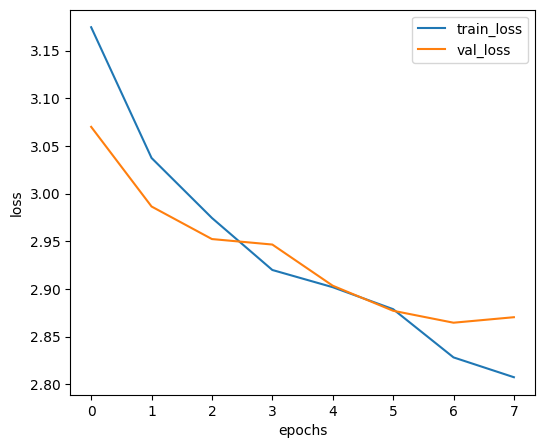

In [ ]:
loss, acc, val_loss, val_acc = zip(*history)
plt.figure(figsize=(6, 5))
plt.plot(loss, label="train_loss")
plt.plot(val_loss, label="val_loss")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()



Accuracy очень низкое, хотя loss падает,

веса модели были выучены на фотографиях, а не на картинках,

 попробуем разморозить 3 слой (после которого мы прикрутили нашу новую голову)

Пересоздадим модель

In [ ]:
#del MyResNext_m
MyResNext_m_2 = MyResNext(block = Bottleneck, layers= [3, 4, 23, 3],\
                        new_head = True,custom_head_only = True )

head created


In [ ]:
count_parameters(MyResNext_m_2)

+------------------------------+------------+
|           Modules            | Parameters |
+------------------------------+------------+
|         conv1.weight         |    9408    |
|          bn1.weight          |     64     |
|           bn1.bias           |     64     |
|    layer1.0.conv1.weight     |    4096    |
|     layer1.0.bn1.weight      |     64     |
|      layer1.0.bn1.bias       |     64     |
|    layer1.0.conv2.weight     |   36864    |
|     layer1.0.bn2.weight      |     64     |
|      layer1.0.bn2.bias       |     64     |
|    layer1.0.conv3.weight     |   16384    |
|     layer1.0.bn3.weight      |    256     |
|      layer1.0.bn3.bias       |    256     |
| layer1.0.downsample.0.weight |   16384    |
| layer1.0.downsample.1.weight |    256     |
|  layer1.0.downsample.1.bias  |    256     |
|    layer1.1.conv1.weight     |   16384    |
|     layer1.1.bn1.weight      |     64     |
|      layer1.1.bn1.bias       |     64     |
|    layer1.1.conv2.weight     |  

46821714

In [ ]:
MyResNext_m_2.set_params_req_grad(['new_head', 'layer3'])
MyResNext_m_2.set_params_to_train( ['new_head', 'layer3'])

In [ ]:
# now all 3-layer are trainable
count_parameters(MyResNext_m_2)

+------------------------------+------------+
|           Modules            | Parameters |
+------------------------------+------------+
|    layer3.0.conv1.weight     |   131072   |
|     layer3.0.bn1.weight      |    256     |
|      layer3.0.bn1.bias       |    256     |
|    layer3.0.conv2.weight     |   589824   |
|     layer3.0.bn2.weight      |    256     |
|      layer3.0.bn2.bias       |    256     |
|    layer3.0.conv3.weight     |   262144   |
|     layer3.0.bn3.weight      |    1024    |
|      layer3.0.bn3.bias       |    1024    |
| layer3.0.downsample.0.weight |   524288   |
| layer3.0.downsample.1.weight |    1024    |
|  layer3.0.downsample.1.bias  |    1024    |
|    layer3.1.conv1.weight     |   262144   |
|     layer3.1.bn1.weight      |    256     |
|      layer3.1.bn1.bias       |    256     |
|    layer3.1.conv2.weight     |   589824   |
|     layer3.1.bn2.weight      |    256     |
|      layer3.1.bn2.bias       |    256     |
|    layer3.1.conv3.weight     |  

28363050

In [ ]:
MyResNext_m_2  = MyResNext_m_2.to(DEVICE)


In [ ]:
history2 = train(train_dataset, val_dataset, model=MyResNext_m_2, epochs=10, batch_size=264, lr = 0.05)

epoch:   0%|          | 0/10 [00:03<?, ?it/s]


OutOfMemoryError: ignored

In [ ]:
torch.save(MyResNext_m, '/content/gdrive/MyDrive/2023_DLS/1_part/data_simpson/saved_models/MyResNext_m.pth')

In [ ]:
test_dataset = SimpsonsDataset(test_files, mode="test")
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=64)
probs = predict(MyResNext_m, test_loader)


preds = label_encoder.inverse_transform(np.argmax(probs, axis=1))
test_filenames = [path.name for path in test_dataset.files]


In [ ]:

my_submit_MyResNext_m = pd.DataFrame({'Id': test_filenames, 'Expected': preds})
my_submit_MyResNext_m.head()

my_submit_MyResNext_m.to_csv('/content/gdrive/MyDrive/2023_DLS/1_part/data_simpson/subs/my_submit_MyResNext_m.csv', index=False)



Не хватает ГПУ чтобы разморозить 3 слой

Последняя модель показывает плохой результат

* возможно ей не хватает глубины для извлечения признаков (эта модель скорее очень широкая, чем глубокая)

* возможно нужны другие гиперпараметры

Итоговый сабмит сделаем со второй Xception

Score - 0.97449